<a href="https://colab.research.google.com/github/JackPW-lang/BERT/blob/main/BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

setup and data prep

In [ ]:
pip install --upgrade transformers datasets bertviz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.6/157.6 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 92.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 89.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 39.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import torch
from torch.utils.data import DataLoader
from transformers import BertTokenizer, BertModel, BertForSequenceClassification
from torch.optim import AdamW
from transformers import get_scheduler
from datasets import load_dataset
from sklearn.metrics import accuracy_score, f1_score, classification_report
from torch import nn
import numpy as np
import random

# Reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)


3.1 - probing by all 3 strategies (CLS, mean, last-token)

In [ ]:

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split


# Load Pretrained BERT
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = BertModel.from_pretrained("bert-base-uncased").to(device)

# Dataset Class
class NewsDataset(torch.utils.data.Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoded = self.tokenizer(
            self.texts[idx],
            padding="max_length",
            truncation=True,
            max_length=self.max_len,
            return_tensors="pt",
        )
        return {
            "input_ids": encoded["input_ids"].squeeze(0),
            "attention_mask": encoded["attention_mask"].squeeze(0),
            "labels": torch.tensor(self.labels[idx], dtype=torch.long),
        }

# Load and Subsample AG News Dataset
dataset = load_dataset("ag_news")
subset_size = 120000

train_texts = dataset["train"]["text"][:subset_size]
train_labels = dataset["train"]["label"][:subset_size]
test_texts = dataset["test"]["text"]
test_labels = dataset["test"]["label"]

train_ds = NewsDataset(train_texts, train_labels, tokenizer)
test_ds = NewsDataset(test_texts, test_labels, tokenizer)

train_loader = DataLoader(train_ds, batch_size=32)
test_loader = DataLoader(test_ds, batch_size=32)

# Representation Extraction Function
def extract_representations(model, dataloader, tokenizer, device):
    model.eval()
    cls_embeddings = []
    mean_embeddings = []
    last_embeddings = []
    labels = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            output = model(input_ids=input_ids, attention_mask=attention_mask)
            hidden = output.last_hidden_state  # (batch, seq_len, hidden_dim)

            # CLS token (first token)
            cls_emb = hidden[:, 0, :]
            cls_embeddings.append(cls_emb.cpu())

            # Mean over non-padding
            mask = attention_mask.unsqueeze(-1).expand(hidden.shape)
            summed = torch.sum(hidden * mask, 1)
            count = torch.clamp(mask.sum(1), min=1e-9)
            mean_emb = summed / count
            mean_embeddings.append(mean_emb.cpu())

            # Last non-padding token
            last_token_ids = attention_mask.sum(1) - 1
            batch_idx = torch.arange(hidden.size(0))
            last_emb = hidden[batch_idx, last_token_ids, :]
            last_embeddings.append(last_emb.cpu())

            labels.append(batch["labels"].cpu())

    return {
        "cls": torch.cat(cls_embeddings),
        "mean": torch.cat(mean_embeddings),
        "last": torch.cat(last_embeddings),
        "labels": torch.cat(labels),
    }

# Run Extraction
representations_train = extract_representations(bert_model, train_loader, tokenizer, device)
representations_test = extract_representations(bert_model, test_loader, tokenizer, device)

# Probing
strategies = ["cls", "mean", "last"]

for strat in strategies:
    print(f"\n--- Probing using [{strat.upper()}] embeddings ---")

    X_train = representations_train[strat].numpy()
    y_train = representations_train["labels"].numpy()
    X_test = representations_test[strat].numpy()
    y_test = representations_test["labels"].numpy()

    # Logistic Regression
    logreg = LogisticRegression(max_iter=1000)
    logreg.fit(X_train, y_train)
    preds_logreg = logreg.predict(X_test)
    acc_logreg = accuracy_score(y_test, preds_logreg)
    f1_logreg = f1_score(y_test, preds_logreg, average="weighted")
    print(f"[LogReg] Accuracy: {acc_logreg:.4f}, F1: {f1_logreg:.4f}")

    # KNN (with validation tuning)
    X_subtrain, X_val, y_subtrain, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
    best_k = None
    best_val_acc = 0
    for k in range(1, 21):
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_subtrain, y_subtrain)
        val_acc = knn.score(X_val, y_val)
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_k = k

    knn_final = KNeighborsClassifier(n_neighbors=best_k)
    knn_final.fit(X_train, y_train)
    acc_knn = knn_final.score(X_test, y_test)
    print(f"[KNN] Best K: {best_k}, Test Accuracy: {acc_knn:.4f}")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

README.md:   0%|          | 0.00/8.07k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]


--- Probing using [CLS] embeddings ---
[LogReg] Accuracy: 0.9037, F1: 0.9036
[KNN] Best K: 17, Test Accuracy: 0.8889

--- Probing using [MEAN] embeddings ---
[LogReg] Accuracy: 0.9113, F1: 0.9113
[KNN] Best K: 13, Test Accuracy: 0.9193

--- Probing using [LAST] embeddings ---
[LogReg] Accuracy: 0.8997, F1: 0.8996
[KNN] Best K: 7, Test Accuracy: 0.8954


Code to display result number 5.1

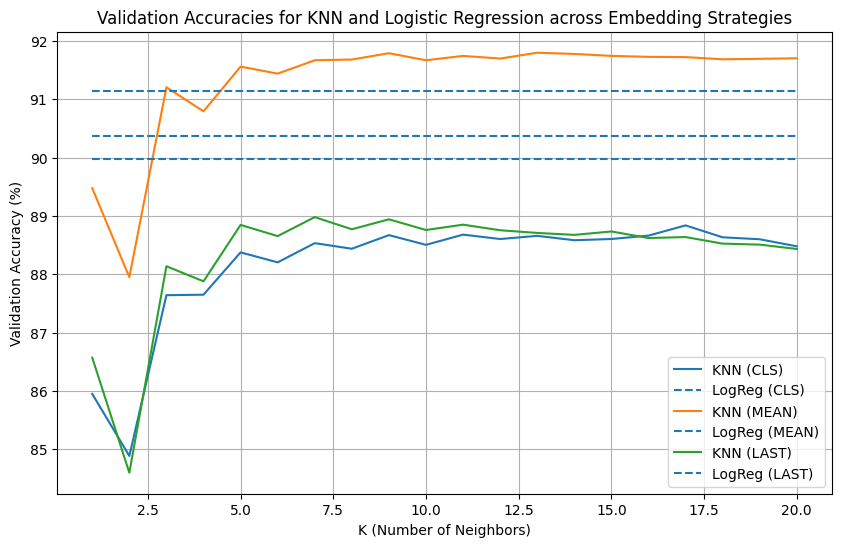

In [ ]:
import matplotlib.pyplot as plt

# Store KNN and LogReg accuracies across strategies
results = {
    "cls": {"knn_acc": [], "logreg_acc": None},
    "mean": {"knn_acc": [], "logreg_acc": None},
    "last": {"knn_acc": [], "logreg_acc": None},
}

k_values = list(range(1, 21))

# Rerun probing loop but store results too
for strat in strategies:
    X_train = representations_train[strat].numpy()
    y_train = representations_train["labels"].numpy()
    X_test = representations_test[strat].numpy()
    y_test = representations_test["labels"].numpy()

    logreg = LogisticRegression(max_iter=1000)
    logreg.fit(X_train, y_train)
    preds_logreg = logreg.predict(X_test)
    acc_logreg = accuracy_score(y_test, preds_logreg) * 100
    results[strat]["logreg_acc"] = acc_logreg

    X_subtrain, X_val, y_subtrain, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

    for k in k_values:
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_subtrain, y_subtrain)
        val_acc = knn.score(X_val, y_val) * 100
        results[strat]["knn_acc"].append(val_acc)

    if strat == "mean":
        acc_probing = acc_logreg  # Save best probing strategy accuracy

# Plot
plt.figure(figsize=(10, 6))

for strat in strategies:
    plt.plot(k_values, results[strat]["knn_acc"], label=f'KNN ({strat.upper()})')
    plt.hlines(results[strat]["logreg_acc"], xmin=1, xmax=20, linestyles='dashed', label=f'LogReg ({strat.upper()})')

plt.xlabel('K (Number of Neighbors)')
plt.ylabel('Validation Accuracy (%)')
plt.title('Validation Accuracies for KNN and Logistic Regression across Embedding Strategies')
plt.legend()
plt.grid(True)
plt.show()


Extra exp - max_iter hyperparameter impact on accuracy

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

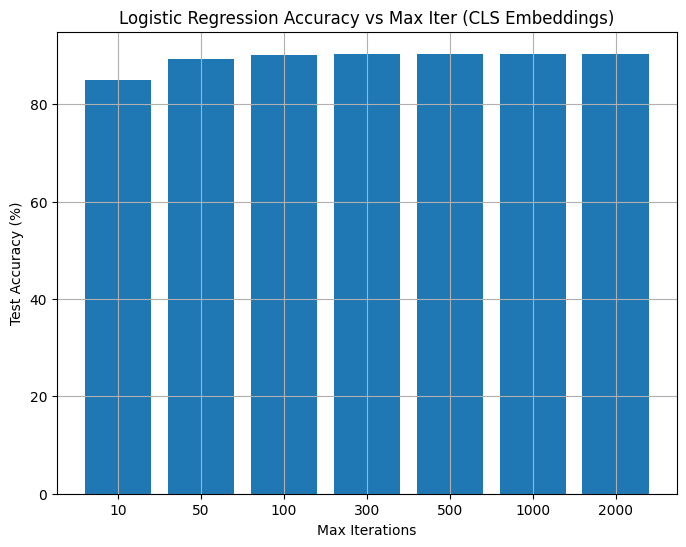

In [ ]:
import matplotlib.pyplot as plt

X_train = representations_train["cls"].numpy()
y_train = representations_train["labels"].numpy()
X_test = representations_test["cls"].numpy()
y_test = representations_test["labels"].numpy()

iters = [10, 50, 100, 300, 500, 1000, 2000]
accs = []

for max_iter in iters:
    logreg = LogisticRegression(max_iter=max_iter)
    logreg.fit(X_train, y_train)
    preds = logreg.predict(X_test)
    acc = accuracy_score(y_test, preds) * 100
    accs.append(acc)

plt.figure(figsize=(8, 6))
plt.bar([str(i) for i in iters], accs)
plt.xlabel('Max Iterations')
plt.ylabel('Test Accuracy (%)')
plt.title('Logistic Regression Accuracy vs Max Iter (CLS Embeddings)')
plt.grid(True)
plt.show()


Extra exp - impact of subset size on accuracy

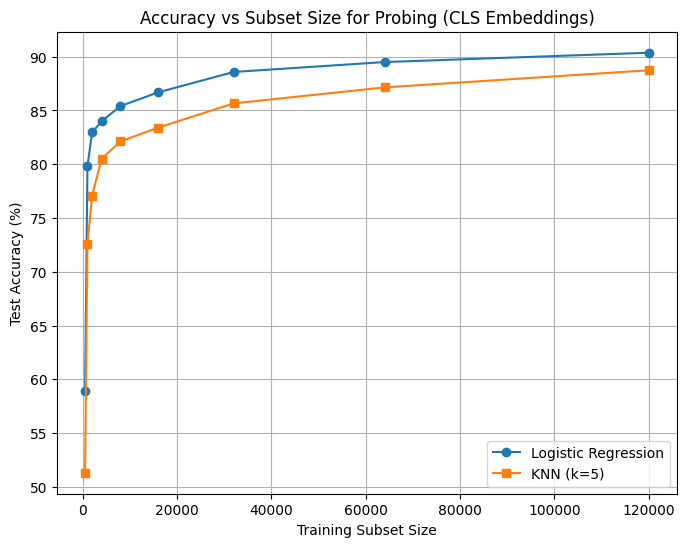

In [ ]:
subset_sizes = [500, 1000, 2000, 4000, 8000, 16000, 32000, 64000, 120000]
logreg_accs = []
knn_accs = []

X_full = representations_train["cls"].numpy()
y_full = representations_train["labels"].numpy()
X_test = representations_test["cls"].numpy()
y_test = representations_test["labels"].numpy()

for size in subset_sizes:
    X_train = X_full[:size]
    y_train = y_full[:size]

    # Logistic Regression
    logreg = LogisticRegression(max_iter=1000)
    logreg.fit(X_train, y_train)
    preds_logreg = logreg.predict(X_test)
    acc_logreg = accuracy_score(y_test, preds_logreg) * 100
    logreg_accs.append(acc_logreg)

    # KNN (using best K found earlier, or set k=10)
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(X_train, y_train)
    preds_knn = knn.predict(X_test)
    acc_knn = accuracy_score(y_test, preds_knn) * 100
    knn_accs.append(acc_knn)

plt.figure(figsize=(8, 6))
plt.plot(subset_sizes, logreg_accs, marker='o', label='Logistic Regression')
plt.plot(subset_sizes, knn_accs, marker='s', label='KNN (k=5)')
plt.xlabel('Training Subset Size')
plt.ylabel('Test Accuracy (%)')
plt.title('Accuracy vs Subset Size for Probing (CLS Embeddings)')
plt.legend()
plt.grid(True)
plt.show()


exp 3.2 - fine tuning

In [ ]:
# ==== 3.2 Fine-Tuning BERT ====

# Split existing 60k train data into train/val for fine-tuning
from sklearn.model_selection import train_test_split
from tqdm import tqdm


fine_tune_texts_train, fine_tune_texts_val, fine_tune_labels_train, fine_tune_labels_val = train_test_split(
    train_texts, train_labels, test_size=0.2, random_state=42)

# Reuse NewsDataset class
fine_tune_train_ds = NewsDataset(fine_tune_texts_train, fine_tune_labels_train, tokenizer)
fine_tune_val_ds = NewsDataset(fine_tune_texts_val, fine_tune_labels_val, tokenizer)
fine_tune_test_ds = NewsDataset(test_texts, test_labels, tokenizer)

fine_tune_train_loader = DataLoader(fine_tune_train_ds, batch_size=16, shuffle=True)
fine_tune_val_loader = DataLoader(fine_tune_val_ds, batch_size=32)
fine_tune_test_loader = DataLoader(fine_tune_test_ds, batch_size=32)

# Load with classifier head
finetune_model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=4).to(device)

optimizer = AdamW(finetune_model.parameters(), lr=2e-5)
num_training_steps = 3 * len(fine_tune_train_loader)

lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

def evaluate_finetune(model, dataloader):
    model.eval()
    preds, targets = [], []
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            preds.extend(torch.argmax(logits, dim=1).cpu().numpy())
            targets.extend(labels.cpu().numpy())

    acc = accuracy_score(targets, preds)
    f1 = f1_score(targets, preds, average="weighted")
    return acc, f1

# Fine-tune for 3 epochs
epochs = 3
best_val_acc = 0

for epoch in range(epochs):
    finetune_model.train()
    total_loss = 0

    for batch in tqdm(fine_tune_train_loader):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = finetune_model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        total_loss += loss.item()

    avg_train_loss = total_loss / len(fine_tune_train_loader)

    val_acc, val_f1 = evaluate_finetune(finetune_model, fine_tune_val_loader)
    print(f"[Epoch {epoch+1}] Train Loss: {avg_train_loss:.4f} | Val Acc: {val_acc:.4f} | Val F1: {val_f1:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(finetune_model.state_dict(), "best_finetuned_bert.pt")

# Final Test Eval
finetune_model.load_state_dict(torch.load("best_finetuned_bert.pt"))
test_acc, test_f1 = evaluate_finetune(finetune_model, fine_tune_test_loader)
print(f"Final Test Accuracy: {test_acc:.4f} | Test F1: {test_f1:.4f}")

acc_finetune = test_acc  # Save final fine-tune accuracy



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 6000/6000 [09:46<00:00, 10.24it/s]


[Epoch 1] Train Loss: 0.2194 | Val Acc: 0.9434 | Val F1: 0.9436


100%|██████████| 6000/6000 [09:43<00:00, 10.28it/s]


[Epoch 2] Train Loss: 0.1233 | Val Acc: 0.9470 | Val F1: 0.9470


100%|██████████| 6000/6000 [09:45<00:00, 10.25it/s]


[Epoch 3] Train Loss: 0.0717 | Val Acc: 0.9468 | Val F1: 0.9468
Final Test Accuracy: 0.9451 | Test F1: 0.9451


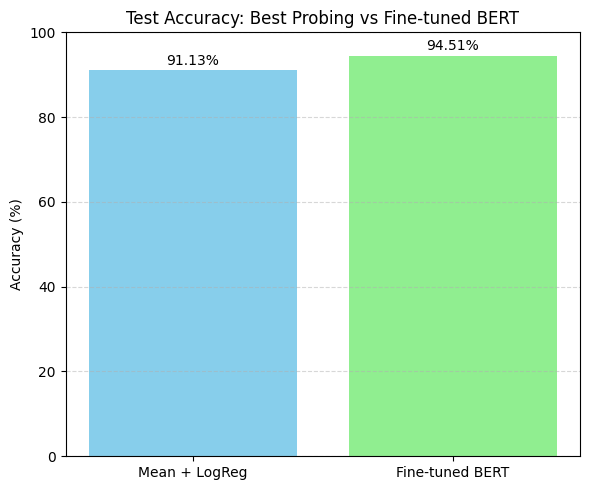

In [ ]:
import matplotlib.pyplot as plt

# Labels + values
models = ["Mean + LogReg", "Fine-tuned BERT"]
accuracies = [acc_probing, acc_finetune * 100]  # Convert to percentage

# Barplot
plt.figure(figsize=(6, 5))
bars = plt.bar(models, accuracies, color=["skyblue", "lightgreen"])

# Annotate values
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.5, f"{acc:.2f}%", ha='center', va='bottom')

plt.title("Test Accuracy: Best Probing vs Fine-tuned BERT")
plt.ylabel("Accuracy (%)")
plt.ylim(0, 100)
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

Experiment 3.4

In [ ]:
from IPython.display import display, HTML
from transformers import BertTokenizer, BertModel, BertForSequenceClassification
from bertviz import head_view

# Load Fine-Tuned Classifier
finetuned_model_for_viz = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=4
).to(device)

finetuned_model_for_viz.load_state_dict(torch.load("best_finetuned_bert.pt"))
finetuned_model_for_viz.eval()

# Extract Encoder for Attention Viz
finetuned_encoder = BertModel.from_pretrained(
    "bert-base-uncased",
    output_attentions=True
).to(device)

finetuned_encoder.load_state_dict(finetuned_model_for_viz.bert.state_dict())
finetuned_encoder.eval()

# Auto-select Examples
correct_pos = None
correct_neg = None
incorrect_pos = None
incorrect_neg = None

for batch in test_loader:
    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    labels = batch["labels"].to(device)

    outputs = finetuned_model_for_viz(input_ids=input_ids, attention_mask=attention_mask)
    preds = torch.argmax(outputs.logits, dim=1)

    for i in range(len(preds)):
        text = tokenizer.decode(input_ids[i], skip_special_tokens=True)

        if preds[i] == labels[i]:
            if labels[i] == 1 and correct_pos is None:
                correct_pos = text
            if labels[i] == 0 and correct_neg is None:
                correct_neg = text
        else:
            if labels[i] == 1 and incorrect_pos is None:
                incorrect_pos = text
            if labels[i] == 0 and incorrect_neg is None:
                incorrect_neg = text

        if correct_pos and correct_neg and incorrect_pos and incorrect_neg:
            break
    if correct_pos and correct_neg and incorrect_pos and incorrect_neg:
        break

print("Correct Positive:", correct_pos)
print("Correct Negative:", correct_neg)
print("Incorrect Positive:", incorrect_pos)
print("Incorrect Negative:", incorrect_neg)


# Attention Visualization Function
def plot_attention(text, layer, head, label):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True).to(device)
    outputs = finetuned_encoder(**inputs, output_attentions=True)
    attn = outputs.attentions[layer].unsqueeze(0)
    tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0].tolist())

    print(f"{label} Attention Visualization (Layer {layer}, Head {head}):")
    html_obj = head_view(attn, tokens, heads=[head], html_action='return')

    # Zoomed display in Colab
    display(HTML(f'<div style="zoom: 0.6; overflow: auto;">{html_obj.data}</div>'))

    # Save raw HTML to file
    with open(f"{label.replace(' ', '_').lower()}_attention.html", "w") as f:
        f.write(html_obj.data)

# Visualize All 4
layer = 8
head = 3

plot_attention(correct_pos, layer, head, "Correct Positive")
plot_attention(correct_neg, layer, head, "Correct Negative")
plot_attention(incorrect_pos, layer, head, "Incorrect Positive")
plot_attention(incorrect_neg, layer, head, "Incorrect Negative")


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
BertSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


Correct Positive: giddy phelps touches gold for first time michael phelps won the gold medal in the 400 individual medley and set a world record in a time of 4 minutes 8. 26 seconds.
Correct Negative: sister of man who died in vancouver police custody slams chief ( canadian press ) canadian press - vancouver ( cp ) - the sister of a man who died after a violent confrontation with police has demanded the city's chief constable resign for defending the officer involved.
Incorrect Positive: french take gold, bronze in single kayak athens, greece - winning on whitewater runs in the family for frenchman benoit peschier, though an olympic gold is something new. peschier paddled his one - man kayak aggressively but penalty free in both his semifinal and final runs on the manmade olympic...
Incorrect Negative: venezuela prepares for chavez recall vote supporters and rivals warn of possible fraud ; government says chavez's defeat could produce turmoil in world oil market.
Correct Positive Atten

Correct Negative Attention Visualization (Layer 8, Head 3):


Incorrect Positive Attention Visualization (Layer 8, Head 3):


Incorrect Negative Attention Visualization (Layer 8, Head 3):
